In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Verified

In [ ]:
import requests
import pandas as pd
import time
import os
import signal
import logging
from dotenv import load_dotenv
from datetime import datetime, time as dt_time
from pytz import timezone
from pandas.tseries.holiday import USFederalHolidayCalendar

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load environment variables
load_dotenv()

# Parameters
window_size = 30  # Number of most recent prices to keep in the window
interval = 86400  # Fetch new price every 24 hours
api_key = os.getenv("API_KEY")  # Finnhub API key

def is_trading_time():
    now = datetime.now(timezone('US/Eastern'))
    
    # Check if it's a weekday
    if now.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return False
    
    # Check if it's a holiday
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=now.date(), end=now.date())
    if now.date() in holidays:
        return False
    
    # Check if it's within market hours (9:30 AM to 4:00 PM Eastern Time)
    market_start = dt_time(9, 30)
    market_end = dt_time(16, 0)
    current_time = now.time()
    
    return market_start <= current_time <= market_end

def fetch_latest_price(ticker):
    """Fetch the latest stock price from Finnhub API."""
    url = f"https://finnhub.io/api/v1/quote?symbol={ticker}&token={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        data = response.json()
        
        if 'c' in data:
            latest_price = data['c']  # Current price
            return (time.strftime('%Y-%m-%d %H:%M:%S'), latest_price)
        else:
            logging.error(f"Error fetching data for {ticker}: {data.get('error', 'Unknown error')}")
            return (None, None)
    except requests.RequestException as e:
        logging.error(f"Failed to get ticker '{ticker}' due to: {e}")
        return (None, None)

def get_valid_ticker():
    """Ask the user for a valid ticker until one is provided."""
    while True:
        ticker = input("Please enter a valid stock ticker: ").upper()
        timestamp, price = fetch_latest_price(ticker)
        if price is not None:
            logging.info(f"Valid ticker '{ticker}' provided.")
            return ticker
        else:
            logging.warning(f"'{ticker}' is not a valid stock ticker or data could not be retrieved. Please try again.")

def update_csv(stock_data, recent_csv_file, historical_csv_file, ticker):
    """Update both recent and historical CSV files."""
    if not is_trading_time():
        logging.info(f"Not trading time. Skipping update at {datetime.now(timezone('US/Eastern'))}")
        return stock_data

    timestamp, price = fetch_latest_price(ticker)
    
    if price is not None:
        new_data = pd.DataFrame({"Datetime": [timestamp], "Price": [price]})
        
        # Update recent CSV with moving window
        stock_data = pd.concat([stock_data, new_data], ignore_index=True).tail(window_size)
        stock_data.to_csv(recent_csv_file, index=False)
        logging.info(f"Updated recent CSV at {timestamp} with price {price}")
        
        # Append to historical CSV without window constraint
        if os.path.exists(historical_csv_file):
            historical_data = pd.read_csv(historical_csv_file)
        else:
            historical_data = pd.DataFrame(columns=["Datetime", "Price"])
        historical_data = pd.concat([historical_data, new_data], ignore_index=True)
        historical_data.to_csv(historical_csv_file, index=False)
        logging.info(f"Updated historical CSV at {timestamp} with price {price}")
        
    else:
        logging.error(f"Failed to fetch data for ticker {ticker}")

    return stock_data

def signal_handler(signum, frame):
    logging.info("Received termination signal. Exiting gracefully...")
    exit(0)

# Main script
if __name__ == "__main__":
    # Set up signal handlers for graceful termination
    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)

    # Get the current working directory (notebooks)
    current_dir = os.getcwd()

    # Go up one level to the parent directory
    parent_dir = os.path.dirname(current_dir)

    # Construct the paths to the stock_data directories
    recent_data_dir = os.path.join(parent_dir, "stock_data_recent")
    historical_data_dir = os.path.join(parent_dir, "stock_data_historical")

    # Create directories if they don't exist
    os.makedirs(recent_data_dir, exist_ok=True)
    os.makedirs(historical_data_dir, exist_ok=True)

    ticker = get_valid_ticker()
    recent_csv_file = os.path.join(recent_data_dir, f"{ticker}_recent.csv")
    historical_csv_file = os.path.join(historical_data_dir, f"{ticker}_historical.csv")

    # Initialize or load existing recent data CSV file
    try:
        stock_data = pd.read_csv(recent_csv_file)
    except FileNotFoundError:
        stock_data = pd.DataFrame(columns=["Datetime", "Price"])

    # Main loop to continuously fetch data and update the CSV
    try:
        while True:
            stock_data = update_csv(stock_data, recent_csv_file, historical_csv_file, ticker)
            time.sleep(interval)
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
    finally:
        logging.info("Script execution ended.")

2024-10-26 16:06:27,208 - ERROR - Failed to get ticker 'NVDA' due to: HTTPSConnectionPool(host='finnhub.io', port=443): Max retries exceeded with url: /api/v1/quote?symbol=NVDA&token=csdgampr01qi0n6eov6gcsdgampr01qi0n6eov70 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002ACB2448C50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
2024-10-26 16:06:27,209 - WARNING - 'NVDA' is not a valid stock ticker or data could not be retrieved. Please try again.
2024-10-26 16:06:31,439 - INFO - Valid ticker 'NVDA' provided.
2024-10-26 16:06:35,864 - INFO - Not trading time. Skipping update at 2024-10-26 16:06:35.864865-04:00


Verified

File found: C:\Users\rauna\PycharmProjects\Derivative_Based_Stock_Prediction\stock_data_recent\NVDA.csv
Degree 2: Train MSE = 0.0081, Test MSE = 0.0505
Degree 3: Train MSE = 0.0014, Test MSE = 0.0365
Degree 4: Train MSE = 0.0002, Test MSE = 0.0186


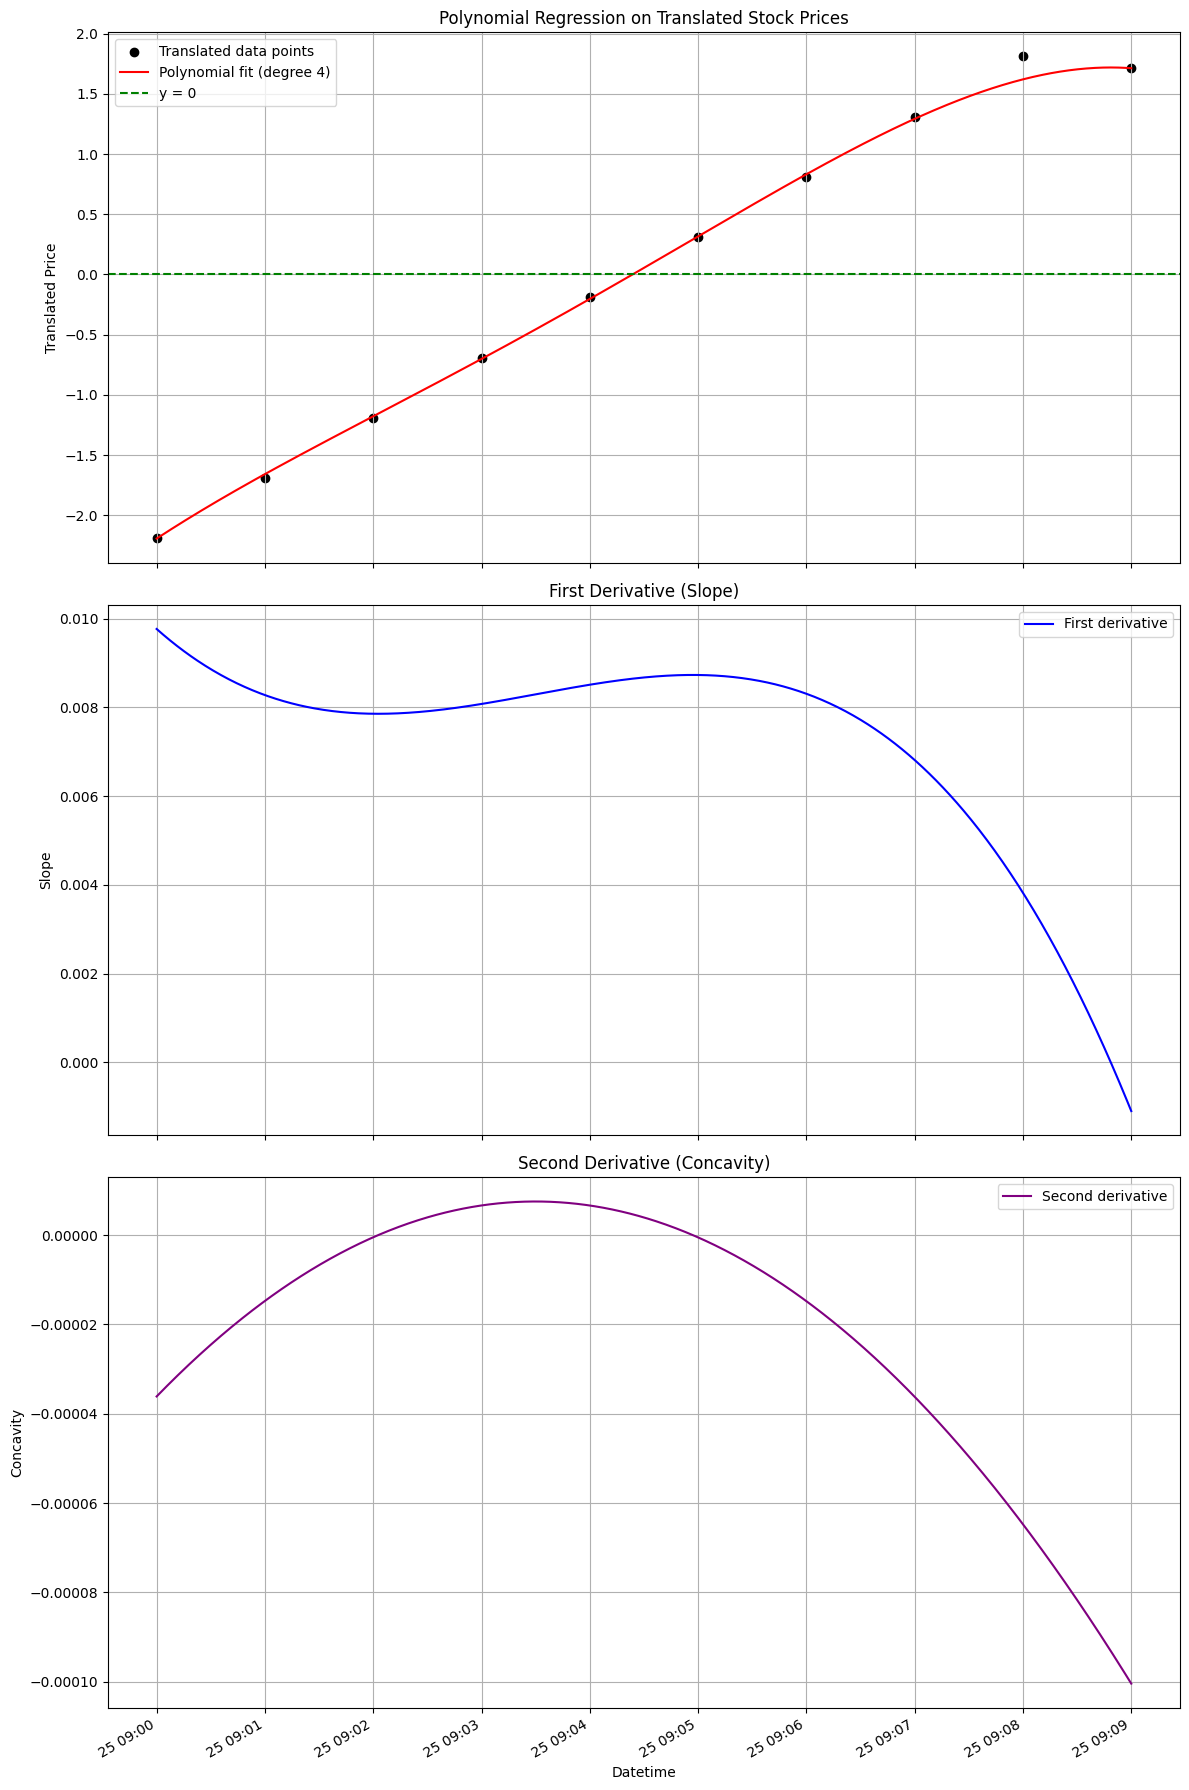


Best polynomial coefficients (highest degree first):
  -8.2585e-11 * x^4
  6.9342e-08 * x^3
  -1.8068e-05 * x^2
  9.7704e-03 * x^1
  -2.1919e+00 * x^0

Regression function:
            4             3             2
-8.258e-11 x + 6.934e-08 x - 1.807e-05 x + 0.00977 x - 2.192

Derivative function (for slope):
            3            2
-3.303e-10 x + 2.08e-07 x - 3.614e-05 x + 0.00977

Second derivative function (for concavity):
           2
-9.91e-10 x + 4.16e-07 x - 3.614e-05

Prediction for the next 1/4 section:
Predicted slope: -0.0214
Predicted concavity: -0.0002

Projected price at 2024-10-25 09:11:15: $142.54

Based on the analysis, the polynomial is predicted to be decreasing with downward curvature in the next 1/4 section of the graph.

Relative extrema within the data range:
Maximum at 2024-10-25 09:08:48: $143.91

Predicted relative extrema in the next 1/4 section:


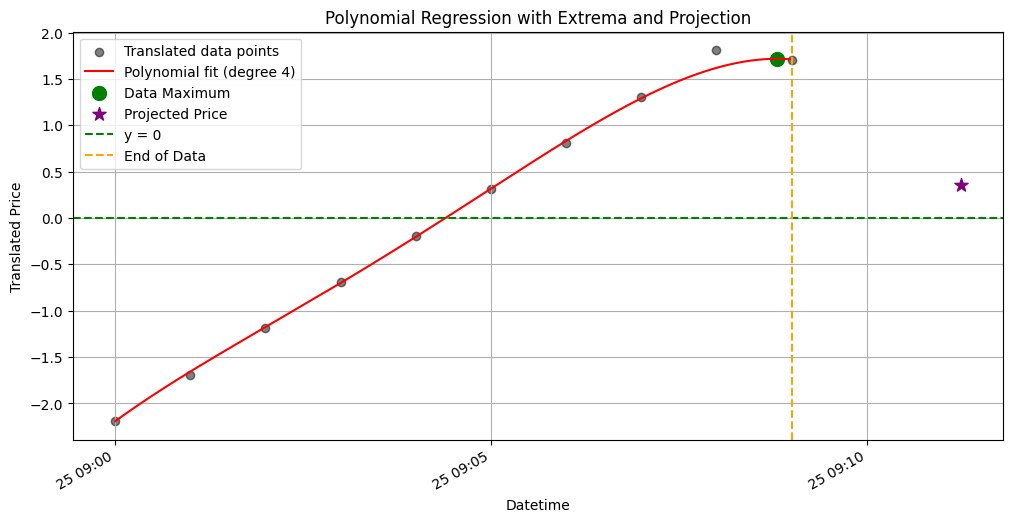

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def get_valid_csv_filename():
    while True:
        base_filename = input("Enter the base name of the CSV file (without .csv extension): ")
        filename = f"{base_filename}.csv"
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        stock_data_dir = os.path.join(parent_dir, "stock_data_recent")
        full_path = os.path.join(stock_data_dir, filename)
        
        if os.path.isfile(full_path):
            print(f"File found: {full_path}")
            return full_path
        else:
            print(f"File not found: {filename}")
            print("Please try again.")

def fit_and_evaluate(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    y_pred = p(x)
    mse = mean_squared_error(y, y_pred)
    return coeffs, p, mse

def find_extrema(p, dp, d2p, x_min, x_max, n_points=1000):
    x_vals = np.linspace(x_min, x_max, n_points)
    y_vals = dp(x_vals)
    
    # Find where the derivative changes sign
    sign_changes = np.where(np.diff(np.sign(y_vals)))[0]
    
    extrema = []
    for idx in sign_changes:
        x_extremum = (x_vals[idx] + x_vals[idx + 1]) / 2
        y_extremum = p(x_extremum)
        if d2p(x_extremum) > 0:
            extremum_type = "Minimum"
        elif d2p(x_extremum) < 0:
            extremum_type = "Maximum"
        else:
            extremum_type = "Inflection point"
        
        extrema.append((x_extremum, y_extremum, extremum_type))
    
    return extrema

# Get a valid CSV file path
csv_file = get_valid_csv_filename()

# Read the CSV file
df = pd.read_csv(csv_file)

# Convert Datetime to numeric values for regression
df['Datetime'] = pd.to_datetime(df['Datetime'])
x = (df['Datetime'] - df['Datetime'].min()).dt.total_seconds().values

# Extract prices
prices = df['Price'].values

# Compute average price and translate prices
avg_price = np.mean(prices)
translated_prices = prices - avg_price

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, translated_prices, test_size=0.2, random_state=42)

# Fit polynomials of degree 2, 3, and 4
degrees = [2, 3, 4]
models = []

for degree in degrees:
    coeffs, p, mse = fit_and_evaluate(x_train, y_train, degree)
    test_mse = mean_squared_error(y_test, p(x_test))
    models.append((degree, coeffs, p, mse, test_mse))
    print(f"Degree {degree}: Train MSE = {mse:.4f}, Test MSE = {test_mse:.4f}")

# Select the best model (lowest test MSE)
best_model = min(models, key=lambda m: m[4])
degree, coeffs, p, _, _ = best_model

# Generate points for plotting the fitted curve
x_plot = np.linspace(x.min(), x.max(), 1000)
y_plot = p(x_plot)

# Calculate derivatives
dp = p.deriv()
d2p = dp.deriv()

# Plot the original data, fitted curve, and derivatives
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Original data and fitted curve
ax1.scatter(df['Datetime'], translated_prices, color='black', label='Translated data points')
ax1.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), y_plot, color='red', label=f'Polynomial fit (degree {degree})')
ax1.axhline(y=0, color='green', linestyle='--', label='y = 0')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Translated Price')
ax1.set_title('Polynomial Regression on Translated Stock Prices')
ax1.legend()
ax1.grid(True)

# First derivative
ax2.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), dp(x_plot), color='blue', label='First derivative')
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Slope')
ax2.set_title('First Derivative (Slope)')
ax2.legend()
ax2.grid(True)

# Second derivative
ax3.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), d2p(x_plot), color='purple', label='Second derivative')
ax3.set_xlabel('Datetime')
ax3.set_ylabel('Concavity')
ax3.set_title('Second Derivative (Concavity)')
ax3.legend()
ax3.grid(True)

plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.tight_layout()
plt.show()

# Print the polynomial coefficients
print("\nBest polynomial coefficients (highest degree first):")
for i, coef in enumerate(coeffs):
    print(f"  {coef:.4e} * x^{degree - i}")

# Print the regression function
print("\nRegression function:")
print(p)

# Print the derivative function
print("\nDerivative function (for slope):")
print(dp)

# Print the second derivative function
print("\nSecond derivative function (for concavity):")
print(d2p)

# Predict behavior and prices for the next 1/4 section
x_range = x.max() - x.min()
x_pred = x.max() + 0.25 * x_range
y_pred = p(x_pred)
slope_pred = dp(x_pred)
concavity_pred = d2p(x_pred)

print("\nPrediction for the next 1/4 section:")
print(f"Predicted slope: {slope_pred:.4f}")
print(f"Predicted concavity: {concavity_pred:.4f}")

# Calculate projected price
projected_price = y_pred + avg_price
projected_date = df['Datetime'].max() + timedelta(seconds=int(0.25 * x_range))

print(f"\nProjected price at {projected_date}: ${projected_price:.2f}")

if slope_pred > 0:
    trend = "increasing"
elif slope_pred < 0:
    trend = "decreasing"
else:
    trend = "stable"

if concavity_pred > 0:
    curvature = "upward"
elif concavity_pred < 0:
    curvature = "downward"
else:
    curvature = "linear"

print(f"\nBased on the analysis, the polynomial is predicted to be {trend} with {curvature} curvature in the next 1/4 section of the graph.")

# Find relative extrema
data_extrema = find_extrema(p, dp, d2p, x.min(), x.max())
predicted_extrema = find_extrema(p, dp, d2p, x.max(), x_pred)

print("\nRelative extrema within the data range:")
for x_ext, y_ext, ext_type in data_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    price = y_ext + avg_price
    print(f"{ext_type} at {date}: ${price:.2f}")

print("\nPredicted relative extrema in the next 1/4 section:")
for x_ext, y_ext, ext_type in predicted_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    price = y_ext + avg_price
    print(f"{ext_type} at {date}: ${price:.2f}")

# Visualize the extrema
plt.figure(figsize=(12, 6))
plt.scatter(df['Datetime'], translated_prices, color='black', label='Translated data points', alpha=0.5)
plt.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), y_plot, color='red', label=f'Polynomial fit (degree {degree})')

# Plot data range extrema
for x_ext, y_ext, ext_type in data_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    plt.scatter(date, y_ext, color='green', s=100, marker='o', label=f'Data {ext_type}' if ext_type not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot predicted range extrema
for x_ext, y_ext, ext_type in predicted_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    plt.scatter(date, y_ext, color='blue', s=100, marker='s', label=f'Predicted {ext_type}' if ext_type not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot the projected price point
plt.scatter(projected_date, y_pred, color='purple', s=100, marker='*', label='Projected Price')

plt.axhline(y=0, color='green', linestyle='--', label='y = 0')
plt.axvline(x=df['Datetime'].max(), color='orange', linestyle='--', label='End of Data')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Translated Price')
plt.title('Polynomial Regression with Extrema and Projection')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

Verified

In [4]:
import os
import pandas as pd
from datetime import datetime

# File paths
trade_log_dir = "trade_logs"
os.makedirs(trade_log_dir, exist_ok=True)
trade_log_file = os.path.join(trade_log_dir, "trade_log.csv")

# Initial portfolio settings
starting_cash = 500.0
cash_balance = starting_cash
shares_held = 0  # Initial share count

# Initialize or load existing trade log CSV
if os.path.exists(trade_log_file):
    trade_log = pd.read_csv(trade_log_file)
    if not trade_log.empty:
        # Load latest cash balance and shares held
        cash_balance = trade_log.iloc[-1]["Cash Balance"]
        shares_held = trade_log.iloc[-1]["Shares Held"]
else:
    trade_log = pd.DataFrame(columns=["Datetime", "Action", "Price", "Shares Traded", "Cash Balance", "Shares Held"])

# Load historical stock data for percentile calculations
historical_csv_file = os.path.join(historical_data_dir, f"{ticker}_historical.csv")
historical_data = pd.read_csv(historical_csv_file)

# Ensure historical data has at least 365 days
if len(historical_data) >= 365:
    recent_prices = historical_data['Close'][-365:]  # Assuming 'Close' is the column with closing prices

    # Calculate the 40th and 70th percentiles
    percentile_40 = recent_prices.quantile(0.40)
    percentile_70 = recent_prices.quantile(0.70)
else:
    raise ValueError("Not enough historical data for percentile-based trading conditions.")

# Predict price and slope for the current and one day ahead
current_x = x[-2]  # Last point
one_day_ahead_x = current_x + 86400  # Predicting for one day ahead

# Use the polynomial to predict price
current_price_pred = p(current_x)
one_day_ahead_price_pred = p(one_day_ahead_x)
current_price_with_avg = current_price_pred + avg_price

# Calculate slopes (first derivative) at both points
current_slope = dp(current_x)
one_day_ahead_slope = dp(one_day_ahead_x)

# Determine action based on slope sign change and percentile conditions
if current_slope > 0 > one_day_ahead_slope and shares_held > 0 and current_price_with_avg >= percentile_70:
    # Sell all shares
    action = "Sell"
    action_price = current_price_with_avg
    shares_traded = shares_held
    cash_balance += action_price * shares_held  # Update cash balance with selling price
    shares_held = 0  # Reset shares held to 0 after selling
    print(f"Sold {shares_traded} shares at ${action_price:.2f} each. Cash balance: ${cash_balance:.2f}")
    
elif current_slope < 0 < one_day_ahead_slope and current_price_with_avg <= percentile_40:
    # Buy maximum shares possible with available cash
    action = "Buy"
    action_price = current_price_with_avg
    shares_traded = int(cash_balance // action_price)  # Calculate max shares that can be bought
    cash_balance -= action_price * shares_traded  # Deduct total cost from cash balance
    shares_held += shares_traded  # Update shares held
    print(f"Bought {shares_traded} shares at ${action_price:.2f} each. Cash balance: ${cash_balance:.2f}")
    
else:
    action = "Hold"
    shares_traded = 0
    action_price = None
    print("Waiting")

# If there was a buy or sell action, log it
if action in ["Buy", "Sell"]:
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    new_trade = pd.DataFrame({
        "Datetime": [timestamp],
        "Action": [action],
        "Price": [action_price],
        "Shares Traded": [shares_traded],
        "Cash Balance": [cash_balance],
        "Shares Held": [shares_held]
    })
    trade_log = pd.concat([trade_log, new_trade], ignore_index=True)
    trade_log.to_csv(trade_log_file, index=False)
    print("Saved Action")

Waiting
